In [1]:
import matplotlib as mpl 
mpl.use("pgf") 
pgf_with_rc_fonts = {
    "font.serif": [],
}

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['axes.facecolor'] = 'w'

In [2]:
%load_ext autoreload
%autoreload 2
from experiment import Runner

In [3]:
exp = Runner(dataset='ML1M')

[exp] ML1M | window_size = 5000, n_epoch = 1
[exp] n_sample = 226310; 45262 (20%) + 22631 (10%) + 158417 (70%)
[exp] n_user = 6014, n_item = 3232


In [4]:
exp_ML100k = Runner(dataset='ML100k')

[exp] ML100k | window_size = 5000, n_epoch = 1
[exp] n_sample = 21201; 4240 (20%) + 2120 (10%) + 14841 (70%)
[exp] n_user = 928, n_item = 1172


In [5]:
# http://public.tableau.com/profile/chris.gerrard#!/vizhome/TableauColors/ColorPaletteswithRGBValues
colors = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
          (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
          (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),   
          (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
          (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# [0, 255] -> [0.0, 1.0]
for i in range(len(colors)): 
    r, g, b = colors[i]    
    colors[i] = (r / 255., g / 255., b / 255.) 

model_colors = [colors[14], colors[0], colors[4], colors[2], colors[6]]

In [97]:
def plot_setting(fig, ax, head=0, T=5000):
    ax.set_xlabel(r'old $\leftarrow$ sample index $\rightarrow$ new', fontsize=11)
    ax.set_ylabel(r'recall$_{%d}$@10' % T, fontsize=11)
    ax.yaxis.grid(True)
    ax.set_yticks([0.00, 0.0125, 0.025, 0.0367, 0.05, 0.0626, 0.075])
    ax.set_yticklabels([0.00, '', 0.025, '', 0.05, '', 0.075])
    ax.set_ylim([0.0, 0.075])
    
    # 30% pre-train | 70% evaluate
    ax.axvline(x=head, linewidth=1, linestyle=':', color=colors[14])
    
    # head-of-evaluate | first 5000 samples (1st window)
    ax.axvline(x=head+5000-1, linewidth=1, linestyle=':', color=colors[14])
    
    fig.set_size_inches((5.5,3))
    fig.patch.set_alpha(0.0)

In [7]:
def show_result(path):
    with open(path) as f:
        lines = map(lambda l: float(l.rstrip()), f.readlines())
        time = lines[0]
        avgs = lines[1:]
        
    fig, ax = plt.subplots()
    ax.plot(np.arange(len(avgs)), avgs)
    plot_setting(fig, ax)
    
    return avgs, time

In [8]:
def read_result(path):
    with open(path) as f:
        lines = map(lambda l: float(l.rstrip()), f.readlines())
        time = lines[0]
        avgs = lines[1:]
    return avgs, time

In [67]:
ML100k_base_avgs, ML100k_base_time = read_result('results/ML100k_baseline_monitor.txt') # reg=0.01, lr=0.0001, epoch=20
ML100k_iMF_avgs, ML100k_iMF_time = read_result('results/ML100k_iMF_monitor.txt') # reg=0.01, lr=0.0001, epoch=20
ML100k_BiMF_avgs, ML100k_BiMF_time = read_result('results/recsys-2016/ML100k/5000/biased-iMF.txt') # epoch=21
ML100k_iFMs_avgs, ML100k_iFMs_time = read_result('results/recsys-2016/ML100k/5000/iFMs_no_context.txt') # epoch=1
ML100k_iFMs_ctx_avgs, ML100k_iFMs_ctx_time = read_result('results/ML100k_iFMs_5000.txt') # epoch=1

ML100k_rand_avgs, ML100k_rand_time = read_result('results/ML100k_random_5000.txt') # epoch=1
ML100k_sketch_avgs, ML100k_sketch_time = read_result('results/ML100k_sketch_5000.txt') # epoch=1

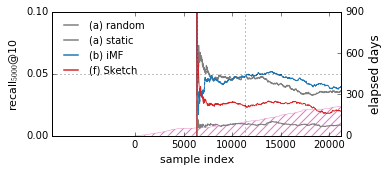

In [68]:
fig, ax = plt.subplots()

# axis #2: the distribution of a 'time' feature
ax2 = ax.twinx()
ax2.plot(exp_ML100k.data.dts, c=colors[12], lw=.4)
ax2.set_xlim((0, exp_ML100k.data.n_sample-1))
ax2.set_yticks([0, 300, 600, 900])
ax2.set_ylim([0, 900])
ax2.fill_between(np.arange(exp_ML100k.data.n_sample), np.array(exp_ML100k.data.dts), facecolor='none', edgecolor=colors[12], lw=0, hatch='///')
ax2.set_ylabel('elapsed days')
#ax2.get_yaxis().set_visible(False)

# axis #1: simple moving average of recall
x = np.arange(len(ML100k_base_avgs))+exp_ML100k.data.n_batch_train+exp_ML100k.data.n_batch_test
ax.plot(x, ML100k_rand_avgs, c=model_colors[0], label='(a) random')
ax.plot(x, ML100k_base_avgs, c=model_colors[0], label='(a) static')
ax.plot(x, ML100k_iMF_avgs, c=model_colors[1], lw=.8, label='(b) iMF')
#ax.plot(x, ML100k_BiMF_avgs, c=model_colors[2], lw=.8, label='(c) iMF-FMs')
#ax.plot(x, ML100k_iFMs_avgs, c=model_colors[3], lw=.8, label='(d) iFMs: no context')
#ax.plot(x, ML100k_iFMs_ctx_avgs, c=model_colors[4], lw=.8, label='(e) iFMs: context')
ax.plot(x, ML100k_sketch_avgs, c=model_colors[4], lw=.8, label='(f) Sketch')
ax.set_xlim((-8500, exp_ML100k.data.n_sample-1))
ax.set_xticks([0, 5000, 10000, 15000, 20000])
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

plot_setting(fig, ax, exp_ML100k.data.n_batch_train+exp_ML100k.data.n_batch_test-1)
fig.set_size_inches((5.5, 2.5))
ax.set_yticks([0.00, 0.05, 0.10])
ax.set_ylim([0.0, 0.10])


leg = ax.legend(fontsize=10, loc='upper left', frameon=False)
for legobj in leg.legendHandles:
    legobj.set_linewidth(1.5)
    
plt.tight_layout()
#fig.savefig('../../paper/images/recsys-2016/ml-100k-recall.eps')

In [91]:
static5000_avgs, static5000_time = read_result('results/ML1M_static-MF_5000.txt') # reg=0.01, lr=0.003, epoch=9
iMF5000_avgs, iMF5000_time = read_result('results/ML1M_iMF_5000.txt') # reg=0.01, lr=0.003, epoch=9

rand5000_avgs, rand5000_time = read_result('results/ML1M_random_5000.txt') # epoch=1

sketch5000_avgs, sketch5000_time = read_result('results/ML1M_sketch_5000.txt')

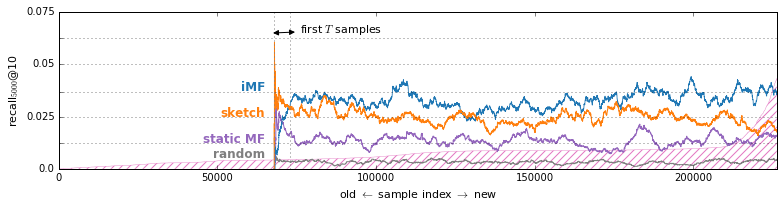

In [118]:
fig, ax = plt.subplots()

# axis #2: the distribution of a 'time' feature
ax2 = ax.twinx()
ax2.plot(exp.data.dts, c=colors[12], lw=.4)
ax2.set_xlim((0, exp.data.n_sample-1))
ax2.set_yticks([0, 600, 1200, 1800])
ax2.set_ylim([0, 1800])
ax2.fill_between(np.arange(exp.data.n_sample), np.array(exp.data.dts), facecolor='none', edgecolor=colors[12], lw=0, hatch='///')
# ax2.set_ylabel('elapsed days')
ax2.get_yaxis().set_visible(False)

# axis #1: simple moving average of recall
n_batch = exp.data.n_batch_train + exp.data.n_batch_test
x = np.arange(len(rand5000_avgs)) + n_batch
ax.plot(x, rand5000_avgs, c=colors[14], label='rand\n%.4f [s]' % rand5000_time)
ax.plot(x, static5000_avgs, c=colors[8], label='static MF\n%.4f [s]' % static5000_time)
ax.plot(x, iMF5000_avgs, c=colors[0], lw=.8, label='iMF\n%.4f [s]' % iMF5000_time)
ax.plot(x, sketch5000_avgs, c=colors[2], label='sketch\n%.4f [s]' % sketch5000_time)
ax.text(65000, 0.0375, 'iMF', color=colors[0], fontsize=12, fontweight='bold', horizontalalignment='right')
ax.text(65000, 0.025, 'sketch', color=colors[2], fontsize=12, fontweight='bold', horizontalalignment='right')
ax.text(65000, 0.0125, 'static MF', color=colors[8], fontsize=12, fontweight='bold', horizontalalignment='right')
ax.text(65000, 0.005, 'random', color=colors[14], fontsize=12, fontweight='bold', horizontalalignment='right')
ax.set_xlim((0, exp.data.n_sample-1))
ax.annotate(r'first $T$ samples', xy=(n_batch-1000, 0.065), xytext=(n_batch+8000, 0.065), size=11, color='k',
            arrowprops=dict(color='k', lw=1., arrowstyle='<|-|>'))
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

plot_setting(fig, ax, exp.data.n_batch_train+exp.data.n_batch_test-1)
fig.set_size_inches((11, 3.))

#leg = ax.legend(fontsize=10, loc='upper left', frameon=False, framealpha=False)
#for legobj in leg.legendHandles:
#    legobj.set_linewidth(1.5)
    
plt.tight_layout()
fig.savefig('../../paper/images/nas-2016/ml-1m-recall-box.eps')